This notebook focuses on generating global explanations for a Facial Expression Recognition (FER) model.
It demonstrates how to:
1. Set up the environment and load the AffectNet dataset with extracted Action Units (AUs).
2. Train and evaluate an XGBoost classifier for FER.
3. Explore global explanations using XGBoost's built-in feature importance.
4. Train an interpretable model (Explainable Boosting Machine - EBM) and visualize its global explanations.
5. Generate Partial Dependency Plots (PDPs) to understand the marginal effect of individual AUs on model predictions.

The goal is to understand how the model makes predictions based on facial action units.

In [ ]:
# fix xgboost incompatiblity issue
%pip uninstall -y -q scikit-learn
%pip install -q scikit-learn==1.5.2
%pip install -q interpret

Cloning into 'xai_ac_sose25'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 35 (delta 11), reused 20 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.51 MiB | 6.74 MiB/s, done.
Resolving deltas: 100% (11/11), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 41.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.7 MB/s eta 

In [ ]:
import sys
import os
# sys.path.append(os.path.realpath('../'))  # uncomment this line if you are running this notebook locally
sys.path.append(os.path.realpath('xai_ac_sose25')) # uncomment this line if you are running this notebook on Google Colab

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io

import utils
import img_utils

In [ ]:
colab = True # change to False if running locally and True if using Colab
base_dir = Path('../data/') if not colab else Path('xai_ac/data/')

In [ ]:
# download the AffectNet dataset extracted features and a sample set of images for visualization
affnet_dir = utils.download_file('https://uni-bielefeld.sciebo.de/s/EmfF9r93LG4jcT9/download',
                          file_name='affectnet_data.zip',
                          cache_dir=base_dir,
                          extract=True,
                          force_download=True,
                          archive_folder='affectnet_data')
affnet_dir

File downloaded to: wise24_xai_ac/data/affectnet_data.zip


PosixPath('wise24_xai_ac/data/affectnet_data')

## Data Loading

### Loading Images and Action Units

In the next cell, you will load csv files that contain extracted actions units and paths to the corresponding images.  

In [ ]:

# Full data from training and evaluation
train_csv = affnet_dir / 'affectnet_aus/train_aus.csv'
val_csv = affnet_dir / 'affectnet_aus/val_aus.csv'

# load training and validation data as pandas dataframes
# action units extracted from the AffectNet dataset via OpenFace
df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)

# smaller dataset for explanations
xai_csv = affnet_dir / 'affectnet_aus/eval_aus.csv'
df_xai = pd.read_csv(xai_csv)
df_xai['image'] = df_xai['image'].str.replace('../data', str(affnet_dir))

# get the class labels
class_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']  # same class labels as before

images = [io.imread(f) for f in df_xai.image]

Here is a feature name map to make AUs values easier to Read in Shap Plots

In [ ]:
# Mapping of Action Units (AUs) to their names
AU_MAP = {
    "AU01": "Inner Brow Raiser",
    "AU02": "Outer Brow Raiser",
    "AU04": "Brow Lowerer",
    "AU05": "Upper Lid Raiser",
    "AU06": "Cheek Raiser",
    "AU07": "Lid Tightener",
    "AU09": "Nose Wrinkler",
    "AU10": "Upper Lip Raiser",
    "AU12": "Lip Corner Puller",
    "AU14": "Dimpler",
    "AU15": "Lip Corner Depressor",
    "AU17": "Chin Raiser",
    "AU20": "Lip Stretcher",
    "AU23": "Lip Tightener",
    "AU25": "Lips Part",
    "AU26": "Jaw Drop",
    "AU28": "Lip Suck",
    "AU45": "Blink",
}

# Generate mappings for both 'r' (regression) and 'c' (classification) versions
AU_FEATURE_MAP = {f"{au}_r": f"{au} - {name} - R" for au, name in AU_MAP.items()}
AU_FEATURE_MAP.update({f"{au}_c": f"{au} - {name} - C" for au, name in AU_MAP.items()})

# Print the mapping
print(AU_FEATURE_MAP)

{'AU01_r': 'AU01 - Inner Brow Raiser - R', 'AU02_r': 'AU02 - Outer Brow Raiser - R', 'AU04_r': 'AU04 - Brow Lowerer - R', 'AU05_r': 'AU05 - Upper Lid Raiser - R', 'AU06_r': 'AU06 - Cheek Raiser - R', 'AU07_r': 'AU07 - Lid Tightener - R', 'AU09_r': 'AU09 - Nose Wrinkler - R', 'AU10_r': 'AU10 - Upper Lip Raiser - R', 'AU12_r': 'AU12 - Lip Corner Puller - R', 'AU14_r': 'AU14 - Dimpler - R', 'AU15_r': 'AU15 - Lip Corner Depressor - R', 'AU17_r': 'AU17 - Chin Raiser - R', 'AU20_r': 'AU20 - Lip Stretcher - R', 'AU23_r': 'AU23 - Lip Tightener - R', 'AU25_r': 'AU25 - Lips Part - R', 'AU26_r': 'AU26 - Jaw Drop - R', 'AU28_r': 'AU28 - Lip Suck - R', 'AU45_r': 'AU45 - Blink - R', 'AU01_c': 'AU01 - Inner Brow Raiser - C', 'AU02_c': 'AU02 - Outer Brow Raiser - C', 'AU04_c': 'AU04 - Brow Lowerer - C', 'AU05_c': 'AU05 - Upper Lid Raiser - C', 'AU06_c': 'AU06 - Cheek Raiser - C', 'AU07_c': 'AU07 - Lid Tightener - C', 'AU09_c': 'AU09 - Nose Wrinkler - C', 'AU10_c': 'AU10 - Upper Lip Raiser - C', 'AU12_

In [ ]:
# update the feature names in the dataframe to be more descriptive
df_train.rename(columns=AU_FEATURE_MAP, inplace=True)
df_val.rename(columns=AU_FEATURE_MAP, inplace=True)
df_xai.rename(columns=AU_FEATURE_MAP, inplace=True)

In [ ]:
# get only the columns storing action units from the dataframe
# there are also facial landmarks and other features in the dataset could be useful
# but we igore them for now and focus on action units
feature_names = [col for col in df_val.columns if col.startswith('AU')]
numerical_features = [feat for feat in feature_names if '- R' in feat]
numerical_idxs = [i for i, feat in enumerate(feature_names) if '- R' in feat]
categorical_features = [feat for feat in feature_names if '- C' in feat]
categorical_idxs = [i for i, feat in enumerate(feature_names) if '- C' in feat]

## Train the XGBoost Model
In this part, we will generate explanations for the XGBoost model trained using a dataset of Facial Action Units (as described in the notebook introduction).  

First, let's load the data and the trained models. Then we will evaluate the model peformance, before we start with the explanations.

In [ ]:
from xgboost import XGBClassifier

### Setup the Datasets

In [ ]:
# we will only use numerical features to remove collinearity with categorical features
X_train = df_train[numerical_features]
y_train = df_train['class']
X_test = df_val[numerical_features]
y_test = df_val['class']

X_xai = df_xai[numerical_features]
y_xai = df_xai['class']

print('Training data shape:', X_train.shape, y_train.shape)
print('Test data shape:', X_test.shape, y_test.shape)
print('XAI data shape:', X_xai.shape, y_xai.shape)

Training data shape: (36685, 17) (36685,)
Test data shape: (3908, 17) (3908,)
XAI data shape: (80, 17) (80,)


### Train the Model

Now let's train the XGBoost Model on the split dataset.

In [ ]:
# # Train model from scratch
random_state = 10
clf = XGBClassifier(max_depth=20, eta=0.1, reg_lambda=3, random_state=random_state)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9962382445141066

### Evaluate the Model


In [ ]:
# get model predictions
y_test_preds = clf.predict(X_test)
y_test_true = y_test

# eval results
print(classification_report(y_test_true, y_test_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.30      0.41      0.35       485
       Happy       0.55      0.65      0.59       488
         Sad       0.37      0.37      0.37       490
    Surprise       0.37      0.34      0.35       488
        Fear       0.43      0.43      0.43       487
     Disgust       0.49      0.34      0.40       493
       Anger       0.36      0.39      0.37       482
    Contempt       0.38      0.25      0.30       495

    accuracy                           0.40      3908
   macro avg       0.40      0.40      0.40      3908
weighted avg       0.40      0.40      0.40      3908



We can also review the confusion matrix to see where the model makes its mistakes

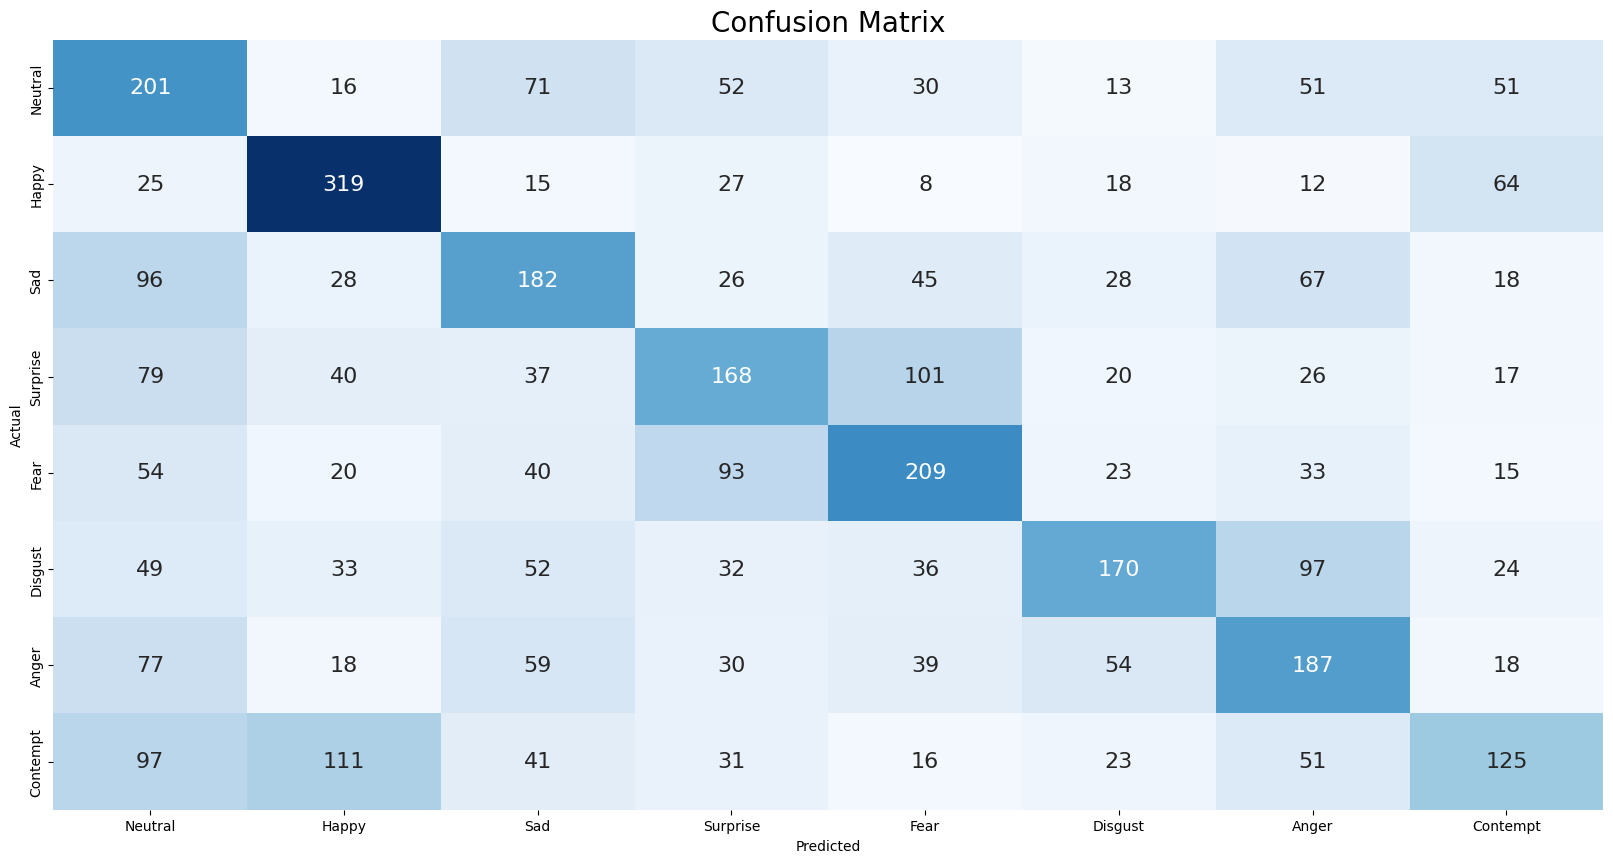

In [ ]:
cm_data = confusion_matrix(y_test_true, y_test_preds)
cm = pd.DataFrame(cm_data, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

### Setup XAI dataset and Predictions

In [ ]:
# Evaluate model on XAI data
y_xai_preds = clf.predict(X_xai)
y_xai_true = y_xai

df_xai['xgb_pred'] = y_xai_preds

print(classification_report(y_xai_true, y_xai_preds, target_names=class_names))

              precision    recall  f1-score   support

     Neutral       0.24      0.40      0.30        10
       Happy       0.64      0.70      0.67        10
         Sad       0.50      0.60      0.55        10
    Surprise       0.38      0.30      0.33        10
        Fear       0.62      0.50      0.56        10
     Disgust       0.50      0.40      0.44        10
       Anger       0.18      0.20      0.19        10
    Contempt       0.60      0.30      0.40        10

    accuracy                           0.42        80
   macro avg       0.46      0.42      0.43        80
weighted avg       0.46      0.42      0.43        80



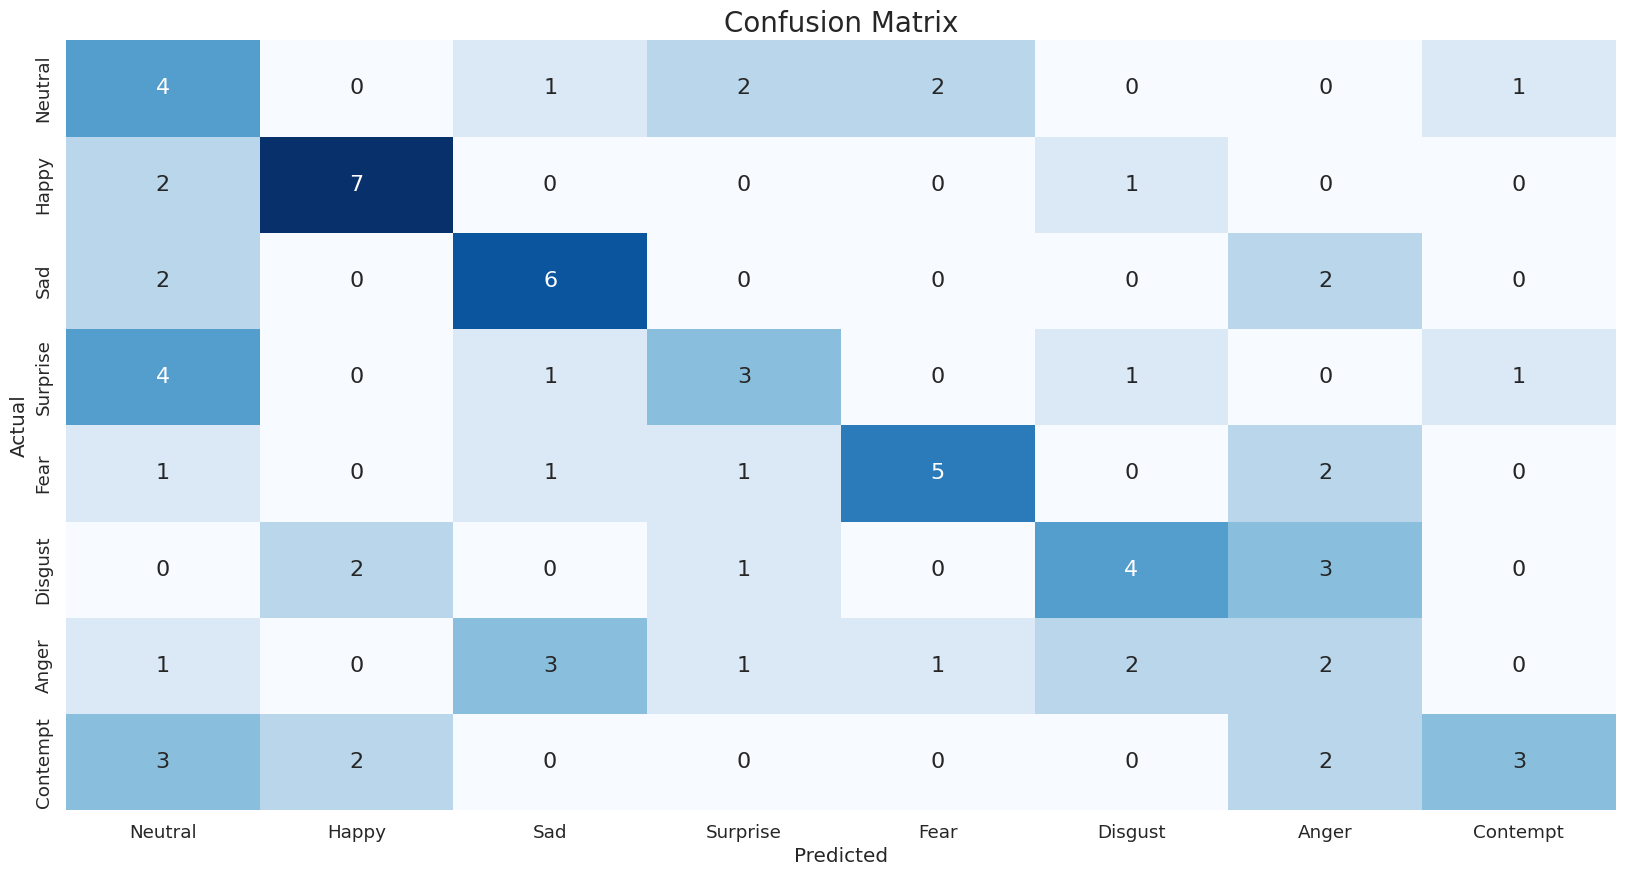

In [ ]:
cm_data = confusion_matrix(y_xai_true, y_xai_preds)
cm = pd.DataFrame(cm_data, columns=class_names, index=class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Explore Some of the Data


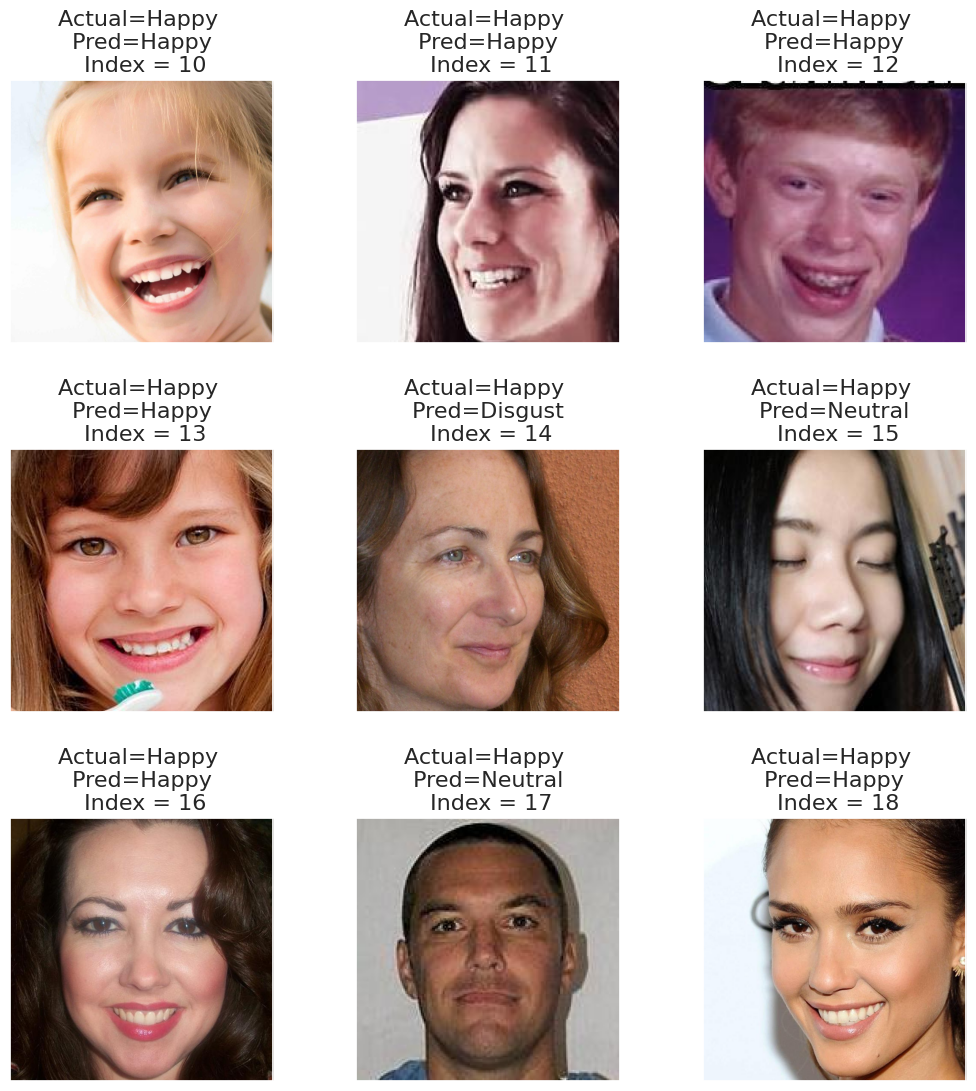

In [ ]:
start=10
img_utils.display_nine_images(images,
                              labels=df_xai['class'],
                              preds=df_xai['xgb_pred'],
                              start=start)

### Generate XGBoost Explanations

Our XGBoost model has builtin feature imporantance values (when using a tree-based model) that show overall feature importances for the model based on the generated trees.

In [ ]:
import xgboost as xgb

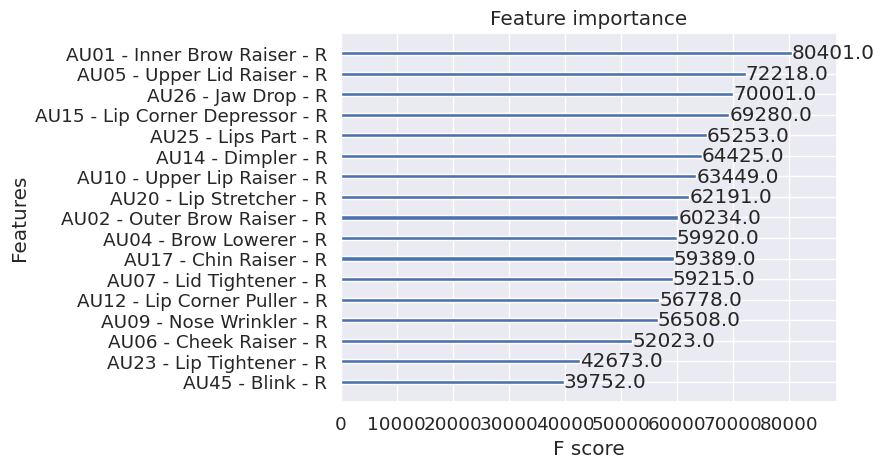

In [ ]:
xgb.plot_importance(clf)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### Train an Interpretable Model

we saw that XGBoost's feature importance values, may not always be consistent. Instead, let's trying training and interpretable (aka GlassBox) model. For this we can use an Explainable Boosting Machine (EBM) from Microsofts [InterpretML library](https://interpret.ml/).


In [ ]:
# install the interpret package (only needed for Google Colab)
if colab:
  %pip install -q interpret

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [ ]:
ebm = ExplainableBoostingClassifier(random_state=random_state)
ebm.fit(X_train, y_train)

ebm_train_score = ebm.score(X_train, y_train)
print(f"EBM Training Accuracy: {ebm_train_score}")

y_xai_preds_ebm = ebm.predict(X_xai)
print(classification_report(y_xai_true, y_xai_preds_ebm, target_names=class_names))

ebm_global = ebm.explain_global()
show(ebm_global)


/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:1173: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


EBM Training Accuracy: 0.3990459315796647
              precision    recall  f1-score   support

     Neutral       0.20      0.30      0.24        10
       Happy       0.60      0.60      0.60        10
         Sad       0.50      0.60      0.55        10
    Surprise       0.33      0.30      0.32        10
        Fear       0.40      0.40      0.40        10
     Disgust       0.44      0.40      0.42        10
       Anger       0.30      0.30      0.30        10
    Contempt       0.40      0.20      0.27        10

    accuracy                           0.39        80
   macro avg       0.40      0.39      0.39        80
weighted avg       0.40      0.39      0.39        80



### Partial Dependency Plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

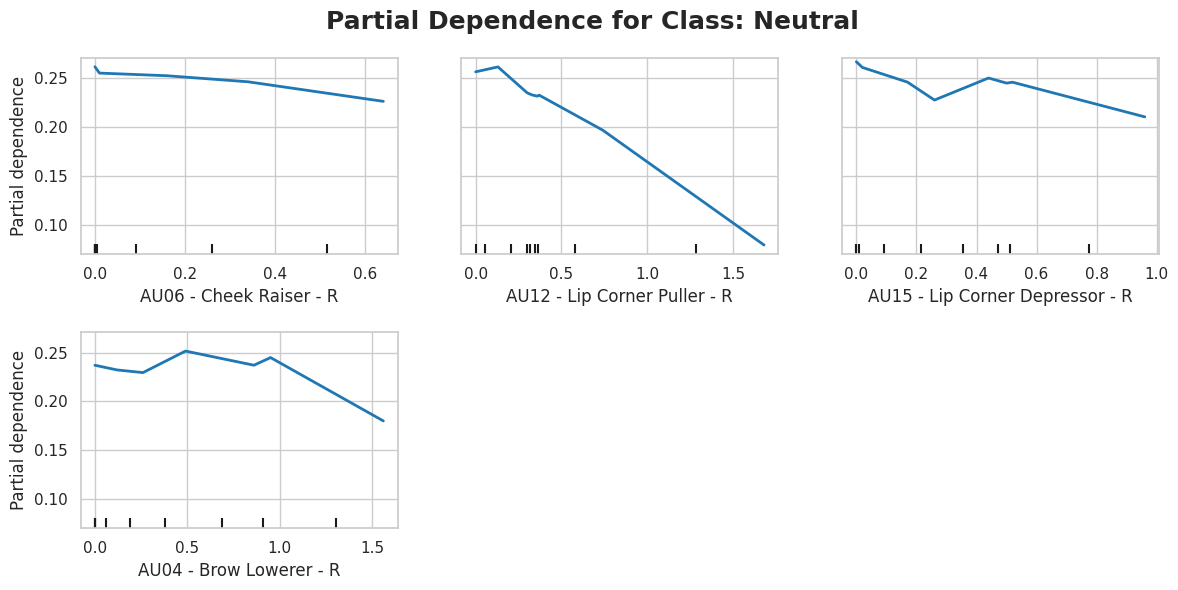

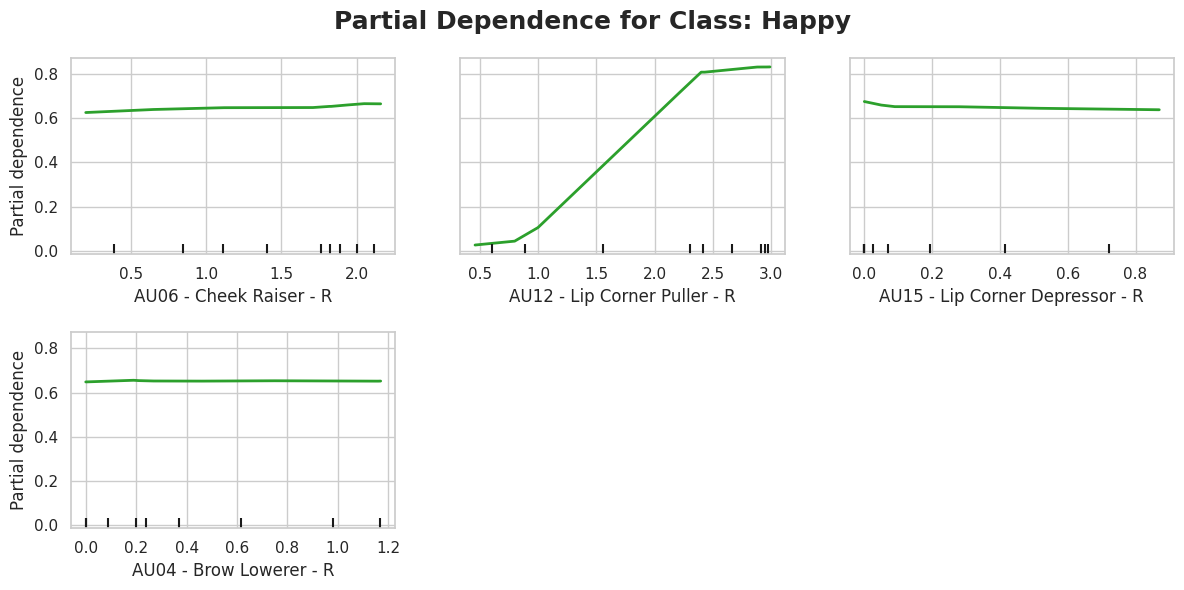

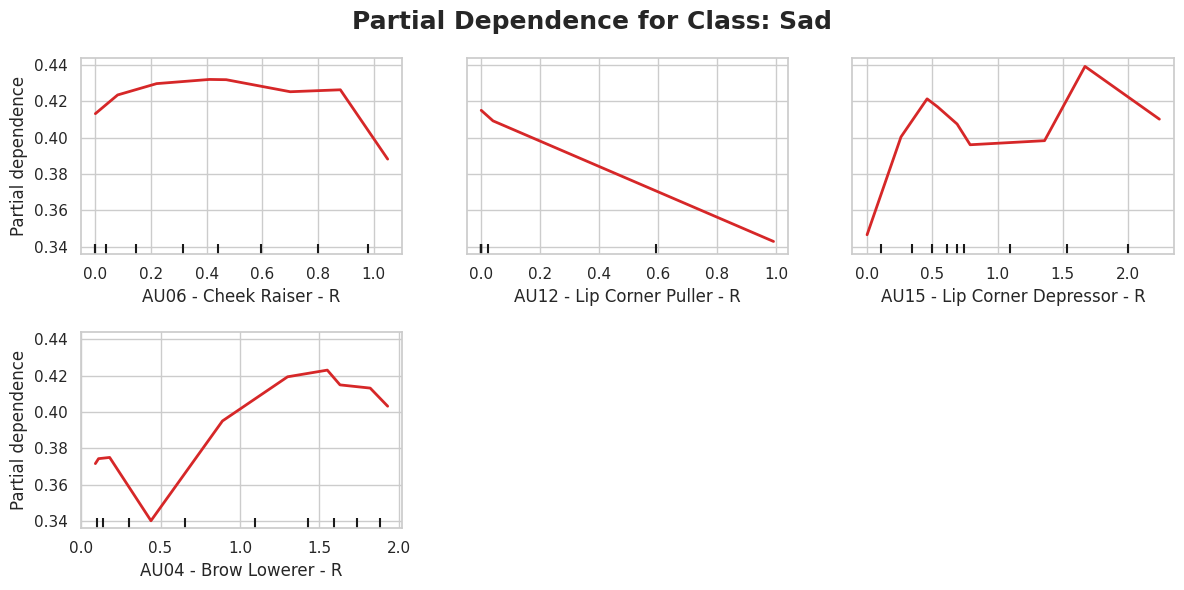

In [ ]:

import seaborn as sns
sns.set(style="whitegrid")


selected_classes = [0, 1, 2]  # Example: Neutral, Happy, Sad
selected_features = [
    'AU06 - Cheek Raiser - R',
    'AU12 - Lip Corner Puller - R',
    'AU15 - Lip Corner Depressor - R',
    'AU04 - Brow Lowerer - R'
]

colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

for idx, class_index in enumerate(selected_classes):
    class_data = X_xai[y_xai == class_index]

    if len(class_data) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        display = PartialDependenceDisplay.from_estimator(
            clf,
            class_data,
            selected_features,
            kind="average",
            target=class_index,
            grid_resolution=50,
            ice_lines_kw={'color': 'lightgray', 'alpha': 0.3, 'linewidth': 0.5},
            pd_line_kw={'color': colors[idx], 'linewidth': 2},
            ax=ax,
            subsample=100
        )

        # Set title and labels
        fig.suptitle(f"Partial Dependence for Class: {class_names[class_index]}", fontsize=18, weight='bold')
        plt.subplots_adjust(top=0.85, hspace=0.4)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for class {class_index}.")

